In [251]:
!pipenv install opencv-python pyautogui Pillow mss

Installing opencv-python...
Resolving opencv-python...
✔ Installation Succeeded
⠋ Installing opencv-python...
Installing pyautogui...
Resolving pyautogui...
✔ Installation Succeeded
⠋ Installing pyautogui...
Installing Pillow...
Resolving Pillow...
✔ Installation Succeeded
⠋ Installing Pillow...
Installing mss...
Resolving mss...
✔ Installation Succeeded
⠋ Installing mss...
Installing dependencies from Pipfile.lock (ecc4ce)...


In [252]:
import cv2
import numpy as np
import pyautogui
import os
import subprocess
import time
from mss import mss
from PIL import Image
from IPython.display import display

In [253]:
# water_img = cv2.imread('water.png', cv2.IMREAD_UNCHANGED)
# lure_img = cv2.imread('lure.png', cv2.IMREAD_UNCHANGED)
# catch_img = cv2.imread('catch.png', cv2.IMREAD_UNCHANGED)
# full_fishing_img = cv2.imread('full_fishing.png', cv2.IMREAD_UNCHANGED)
# full_not_fishing_img = cv2.imread('full_not_fishing.png', cv2.IMREAD_UNCHANGED)

In [254]:
screen_size = pyautogui.size()
screen_size

Size(width=1512, height=982)

In [255]:
target_width = screen_size.width * 0.4
target_height = screen_size.height * 0.25

left = int((screen_size.width - target_width) * 0.5)
top = int((screen_size.height - target_height) * 0.3)

bottom = int(top + target_height)
right = int(left + target_width)

canvas = (left, right, top, bottom)

In [256]:
sct = mss()

In [257]:
command = 'osascript -e \'tell application "System Events" to get name of application processes whose frontmost is true\''

def is_warcraft():
    return 'Warcraft' in subprocess.run(command, shell=True, capture_output=True, text=True).stdout

while not is_warcraft():
    time.sleep(1)

In [258]:
# give me time to use the fishing rod
# time.sleep(2)

In [259]:
# when in wow, press the fisching hotkey
pyautogui.press('x')
time.sleep(1) # animation

In [260]:
monitor = sct.monitors[1]
screen_img = np.array(sct.grab(monitor))
screen_img = cv2.resize(screen_img, (int(screen_size.width), int(screen_size.height)))

In [261]:
# display(Image.fromarray(cv2.cvtColor(screen_img, cv2.COLOR_BGR2RGB)))

In [262]:
screen_img.shape[:2]

(982, 1512)

In [263]:
# have to reshape to a 2D array (currently 1D)
height, width = screen_img.shape[:2]
image_2d = screen_img.reshape((height, width, 4))
(height, width, 4)

(982, 1512, 4)

In [264]:
cropped_image = image_2d[top:bottom, left:right]

In [265]:
# Convert to grayscale
gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

# Noise reduction
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Edge detection
edged = cv2.Canny(blurred, 50, 130)

# Finding contours
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

len(contours)

23

In [266]:
image_center = (cropped_image.shape[1] / 2, cropped_image.shape[0] / 2)

# Initialize variables to store the minimum distance and the corresponding rectangle
min_distance = float('inf')
closest_rectangle = None

for c in contours:
    # Compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    
    # Calculate the center of the rectangle
    rect_center = (x + w / 2, y + h / 2)

    # Compute the Euclidean distance from the image center
    distance = ((rect_center[0] - image_center[0]) ** 2 + (rect_center[1] - image_center[1]) ** 2) ** 0.5

    # Update the minimum distance and rectangle if needed
    if distance < min_distance:
        min_distance = distance
        closest_rectangle = (x, y, w, h)

In [267]:
if closest_rectangle is not None:
    (x, y, w, h) = closest_rectangle
    cv2.rectangle(cropped_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

In [268]:
# for c in contours:
#     # Compute the bounding box of the contour
#     (x, y, w, h) = cv2.boundingRect(c)
    
#     # Draw the bounding box
#     cv2.rectangle(cropped_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

In [269]:
cv2.rectangle(screen_img, (left, top), (right, bottom), (255, 0, 0), 2)
''

''

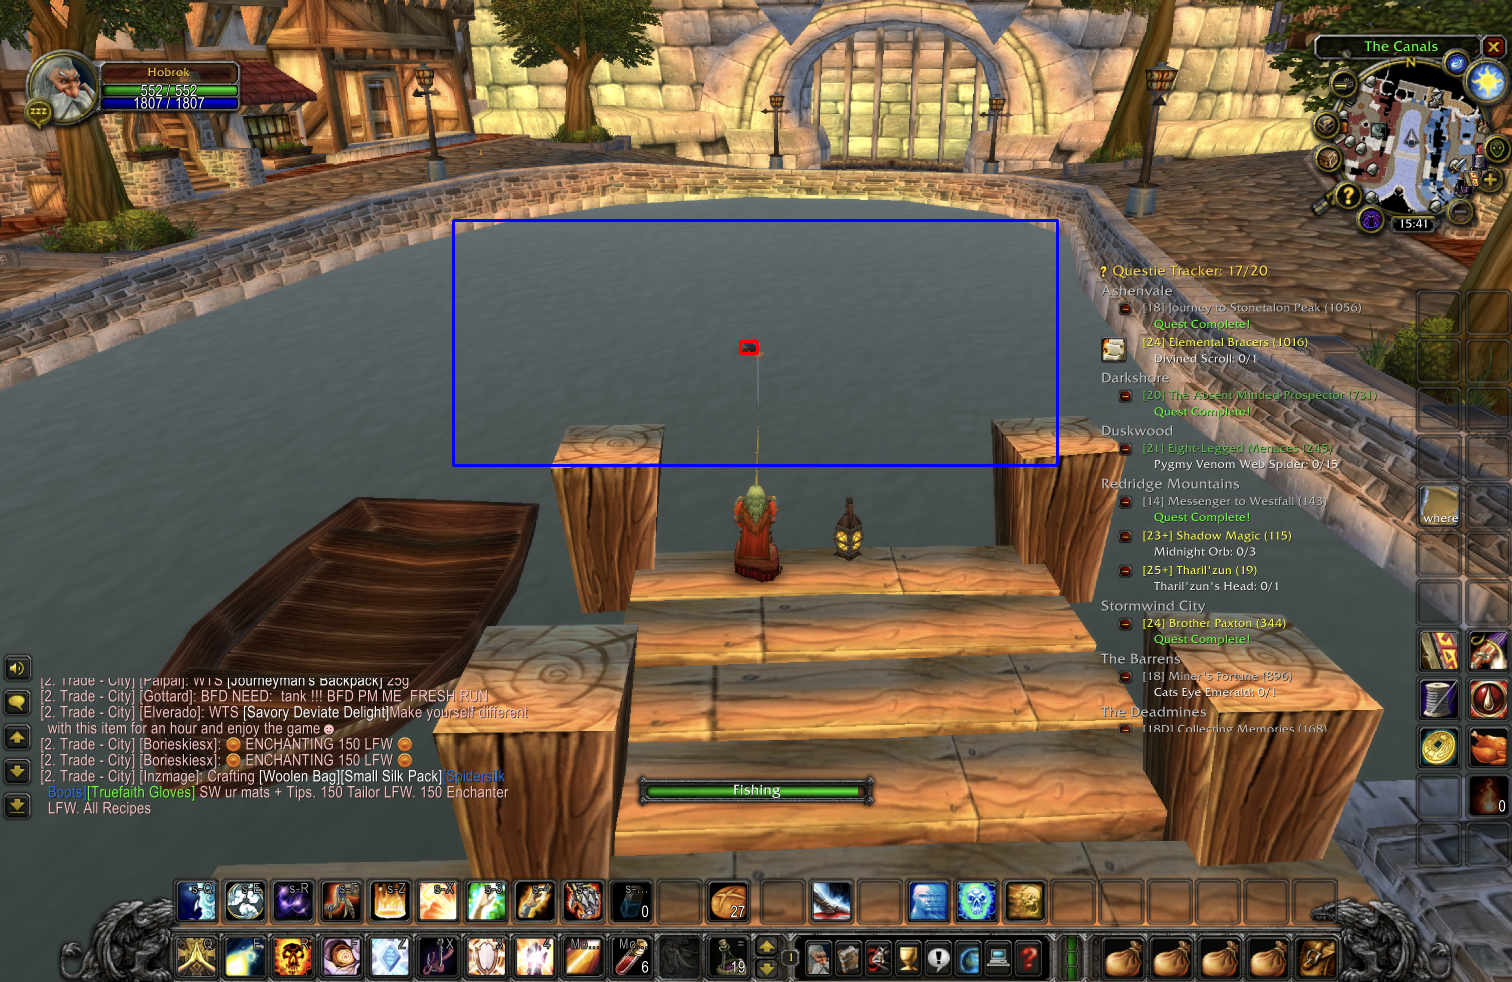

In [270]:
display(Image.fromarray(cv2.cvtColor(screen_img, cv2.COLOR_BGR2RGB)))

In [271]:
(x, y, w, h) = closest_rectangle
(w, h)

(17, 12)

In [272]:
# is_success = closest_rectangle is not None and w > 5 and h > 5 and w < 70 and h < 70
is_success = closest_rectangle is not None
is_success

True

In [273]:
if is_success:
    pyautogui.moveTo(x=x + left + w, y=y + top + h)

In [274]:
# if is_success:
#     os.system('afplay /System/Library/Sounds/Glass.aiff')
# else:
#     os.system('afplay /System/Library/Sounds/Bottle.aiff')

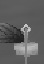

0


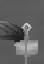

0.848011363636374


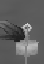

-0.5738636363636402


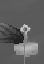

-0.27698863636364024


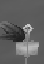

1.328125


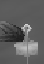

-1.308238636363626


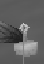

0.466619318181813


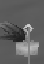

0.23224431818181301


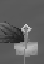

-1.1182528409090935


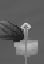

1.6459517045454675


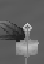

0.11576704545453254


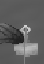

-1.5458096590909065


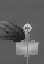

1.271661931818187


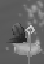

6.3973721590909065
This is a spike!


In [275]:
i = 0
fishing_channeling_length = 20
tickrate = 0.25
margin = 10

prev_brightness = 0

# under this brightness change the pixels to black
threshold = 160

while i < fishing_channeling_length:
    i = i + tickrate

    
    (x, y, w, h) = closest_rectangle
    box = {'top': y + top - 10, 'left': x + left + 5, 'width': w + 5, 'height': h + 20}
    img = np.array(sct.grab(box))

    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # grayscale[grayscale < threshold] = 0

    brightness = np.mean(grayscale)
    brightness_change = 0 if prev_brightness == 0 else brightness - prev_brightness
    
    display(Image.fromarray(cv2.cvtColor(grayscale, cv2.COLOR_BGR2RGB)))
    print(brightness_change)

    if prev_brightness != 0 and brightness_change > 3:
        # if not is_warcraft():
        #     print('WoW is not focused anymore')
        #     break;
            
        print('This is a spike!')
        with pyautogui.hold('shift'):
            pyautogui.click(button='right')
        # os.system('afplay /System/Library/Sounds/Hero.aiff')
        break;

    prev_brightness = brightness
    
    time.sleep(1)